# MovieLens 2-Mode Network Analysis
This notebook explores the MovieLens 100K dataset as a bipartite graph between users and movies. We apply the island method to reduce the graph and analyze projections for each group.

In [2]:
# Step 1: Load Data
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite

# Load ratings (user, movie, rating, timestamp)
ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=["user", "movie", "rating", "timestamp"])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
# Step 2: Build Bipartite Graph (Filter ratings >= 3)
B = nx.Graph()
filtered = ratings[ratings['rating'] >= 3]
B.add_nodes_from(filtered['user'].unique(), bipartite='users')
B.add_nodes_from(filtered['movie'].unique(), bipartite='movies')
edges = list(zip(filtered['user'], filtered['movie']))
B.add_edges_from(edges)

print(f"Bipartite Graph: {B.number_of_nodes()} nodes, {B.number_of_edges()} edges")




Bipartite Graph: 1586 nodes, 79109 edges


In [ ]:
We now project the bipartite graph onto the user nodes. This means that users will be connected to each other if they rated the same movies. The resulting graph will help us analyze relationships between users based on shared preferences.


Sample degrees: [1312, 1059, 1011, 1363, 1119, 1092, 1387, 1047, 1062, 1233]


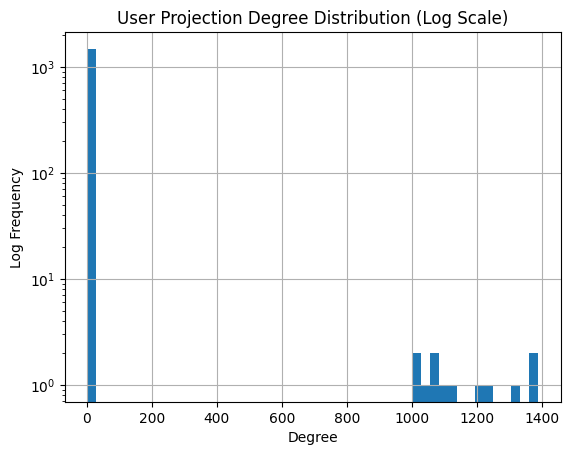

Min degree: 1
Max degree: 1387
Mean degree: 18.668914362778153
Median degree: 12.0


In [4]:
# Step 3: Project onto Users
users = {n for n, d in B.nodes(data=True) if d.get("bipartite") == "users"}
movies = {n for n, d in B.nodes(data=True) if d.get("bipartite") == "movies"}

user_proj = bipartite.weighted_projected_graph(B, users)

# Check degrees
user_degrees = [d for n, d in user_proj.degree()]
print("Sample degrees:", user_degrees[:10])

# Plot
plt.hist(user_degrees, bins=50, log=True)
plt.title("User Projection Degree Distribution (Log Scale)")
plt.xlabel("Degree")
plt.ylabel("Log Frequency")
plt.grid(True)
plt.show()

import numpy as np

print("Min degree:", np.min(user_degrees))
print("Max degree:", np.max(user_degrees))
print("Mean degree:", np.mean(user_degrees))
print("Median degree:", np.median(user_degrees))


We calculate two key centrality measures:

- **Degree Centrality**: Measures how many users a node is directly connected to.
- **Betweenness Centrality**: Measures how often a node acts as a bridge between other users.

This helps us identify the most "important" users in terms of connectivity and influence.


In [6]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(user_proj)
betweenness_centrality = nx.betweenness_centrality(user_proj)

# Show top 5 users by degree centrality
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 users by degree centrality:")
for user, score in top_degree:
    print(f"User {user}: {score:.4f}")

# Show top 5 users by betweenness centrality
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("\nTop 5 users by betweenness centrality:")
for user, score in top_betweenness:
    print(f"User {user}: {score:.4f}")


Top 5 users by degree centrality:
User 437: 0.9359
User 314: 0.9197
User 897: 0.8853
User 442: 0.8320
User 830: 0.8077

Top 5 users by betweenness centrality:
User 437: 0.1786
User 314: 0.1574
User 897: 0.1244
User 442: 0.0899
User 830: 0.0813


From the results above, we can see which users are most central in the network.

- Users with high **degree centrality** are highly connected and likely rate popular movies.
- Users with high **betweenness centrality** may act as bridges between different user groups — possibly exposing niche movies to wider audiences.

These users may be influential in shaping movie trends or ratings.


In [7]:
# Top 10 most connected users
top_users = sorted(user_proj.degree(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 users by degree (shared movie connections):")
for user_id, degree in top_users:
    print(f"User {user_id}: {degree} connections")


Top 10 users by degree (shared movie connections):
User 437: 1387 connections
User 314: 1363 connections
User 897: 1312 connections
User 442: 1233 connections
User 830: 1197 connections
User 784: 1119 connections
User 852: 1092 connections
User 439: 1062 connections
User 599: 1059 connections
User 438: 1047 connections


In [8]:
from networkx.algorithms.community import label_propagation_communities

communities = list(label_propagation_communities(user_proj))
print(f"Detected {len(communities)} communities.")

# Print size of top 5
for i, c in enumerate(sorted(communities, key=len, reverse=True)[:5]):
    print(f"Community {i+1} size:", len(c))


Detected 1 communities.
Community 1 size: 1483


Island graph (users) has 953 nodes and 6289 edges


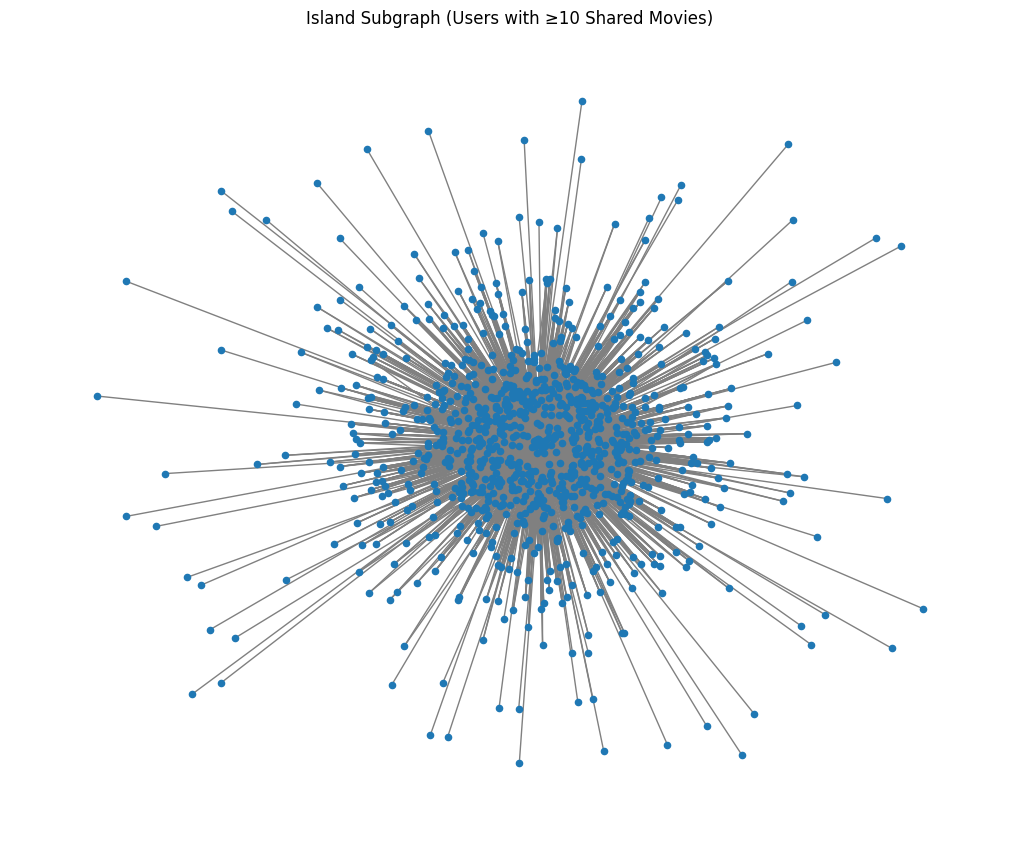

In [9]:
# Step 4: Apply Island Method (filter dense ties)
threshold = 10
island_user = nx.Graph((u, v, d) for u, v, d in user_proj.edges(data=True) if d['weight'] >= threshold)
print(f"Island graph (users) has {island_user.number_of_nodes()} nodes and {island_user.number_of_edges()} edges")

plt.figure(figsize=(10, 8))
nx.draw(island_user, node_size=20, edge_color='gray')
plt.title("Island Subgraph (Users with ≥10 Shared Movies)")
plt.show()

### Final Analysis & Inferences

This analysis modeled the MovieLens 100K dataset as a bipartite graph of users and movies, focusing on meaningful patterns in user behavior.

- After filtering and projecting the network, we observed a **highly skewed degree distribution** — consistent with real-world user activity, where a small group of highly active users interacts with many others.

- Applying the **island method** revealed a dense core of 953 users with strong overlap in preferences (≥10 shared movies). This subgraph is ideal for targeted recommendation strategies.

- Using **degree centrality**, we identified the most connected users — those likely to watch and rate the most popular movies.

- **Betweenness centrality** highlighted key users who act as bridges between communities. These users are potentially important for spreading recommendations or exposing niche films to broader audiences.

- Interestingly, community detection revealed only one dominant cluster, suggesting a high degree of shared tastes across the user base.

In conclusion, this approach demonstrates how network analysis can uncover meaningful insights in recommendation systems. Central users identified here can play a key role in shaping viewing trends and algorithmic suggestions.

